In [25]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP
import os

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from cobrame.util.helper_functions import *

import copy
from scipy import stats
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))
pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jt/work/cobrapy-0.5.11/cobra/__init__.py
/home/jt/work/cobrame/cobrame/__init__.py
/home/jt/work/sporeme/bacillusme/__init__.py


In [26]:
def add_transport_to_model(model,mets):
    for met in mets:
        rxn = cobrame.MEReaction('{}_transport'.format(met))
        model.add_reactions([rxn])
        rxn.add_metabolites({
            '{}_c'.format(met):-1,
            '{}_s'.format(met):1
        })
        rxn.bounds = (-1000,1000)
        print(rxn.reaction)
def add_sinks_to_model(model,mets):
    rlist = []
    for met in mets:
        rxn = cobrame.MEReaction('SK_{}'.format(met))
        model.add_reactions([rxn])
        rxn.add_metabolites({
            met:1
        })
        rxn.bounds = (0,1e-15)
        rlist.append(rxn)
    return rlist

## Setup

In [27]:
with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [28]:
add_transport_to_model(sporeme,['gtp','ctp','utp','gdp','cdp','udp','adp','atp'])

gtp_c <=> gtp_s
ctp_c <=> ctp_s
utp_c <=> utp_s
gdp_c <=> gdp_s
cdp_c <=> cdp_s
udp_c <=> udp_s
adp_c <=> adp_s
atp_c <=> atp_s


In [29]:
genes = [i + '_s' for i in list(pd.read_csv('base_confirmed_depletion_neighborhood_spoAQ.txt',header=None)[1].values)]

In [30]:
cplxs = []
for i in genes:
    m = sporeme.metabolites.get_by_id('protein_'+i)
#     c = find_complex(m)
    cplxs.append(m)
cplxs = set(cplxs)
cplxs

{<TranslatedGene protein_BSU01780_s at 0x7f9c0ddfe350>,
 <TranslatedGene protein_BSU03050_s at 0x7f9c0a954850>,
 <TranslatedGene protein_BSU04030_s at 0x7f9c0b079f90>,
 <TranslatedGene protein_BSU04640_s at 0x7f9c093deb90>,
 <TranslatedGene protein_BSU07840_s at 0x7f9c08714e50>,
 <TranslatedGene protein_BSU09530_s at 0x7f9c0a917590>,
 <TranslatedGene protein_BSU09570_s at 0x7f9c0a917f10>,
 <TranslatedGene protein_BSU11330_s at 0x7f9c0b1273d0>,
 <TranslatedGene protein_BSU11720_s at 0x7f9c0b1007d0>,
 <TranslatedGene protein_BSU14390_s at 0x7f9c0e1334d0>,
 <TranslatedGene protein_BSU14580_s at 0x7f9c0e0d32d0>,
 <TranslatedGene protein_BSU14590_s at 0x7f9c0e0d3a90>,
 <TranslatedGene protein_BSU14600_s at 0x7f9c0e0d3bd0>,
 <TranslatedGene protein_BSU14610_s at 0x7f9c0e0e2250>,
 <TranslatedGene protein_BSU15790_s at 0x7f9c0dd1e750>,
 <TranslatedGene protein_BSU17380_s at 0x7f9c0d953c90>,
 <TranslatedGene protein_BSU17390_s at 0x7f9c0d963410>,
 <TranslatedGene protein_BSU17460_s at 0x7f9c0d9

In [31]:
rlist = add_sinks_to_model(sporeme,cplxs)
[(r.id,r.reaction) for r in rlist]

[('SK_protein_BSU22830_s', ' --> protein_BSU22830_s'),
 ('SK_protein_BSU03050_s', ' --> protein_BSU03050_s'),
 ('SK_protein_BSU27900_s', ' --> protein_BSU27900_s'),
 ('SK_protein_BSU27250_s', ' --> protein_BSU27250_s'),
 ('SK_protein_BSU33930_s', ' --> protein_BSU33930_s'),
 ('SK_protein_BSU27260_s', ' --> protein_BSU27260_s'),
 ('SK_protein_BSU14610_s', ' --> protein_BSU14610_s'),
 ('SK_protein_BSU36010_s', ' --> protein_BSU36010_s'),
 ('SK_protein_BSU14590_s', ' --> protein_BSU14590_s'),
 ('SK_protein_BSU14580_s', ' --> protein_BSU14580_s'),
 ('SK_protein_BSU35920_s', ' --> protein_BSU35920_s'),
 ('SK_protein_BSU22960_s', ' --> protein_BSU22960_s'),
 ('SK_protein_BSU34790_s', ' --> protein_BSU34790_s'),
 ('SK_protein_BSU01780_s', ' --> protein_BSU01780_s'),
 ('SK_protein_BSU29120_s', ' --> protein_BSU29120_s'),
 ('SK_protein_BSU28500_s', ' --> protein_BSU28500_s'),
 ('SK_protein_BSU22370_s', ' --> protein_BSU22370_s'),
 ('SK_protein_BSU21870_s', ' --> protein_BSU21870_s'),
 ('SK_prot

In [32]:
len(rlist)

45

In [33]:
sporeme.objective = rlist

In [34]:
from bacillusme.analysis import sensitivity as ss

In [35]:
solve_me_model(sporeme,
               max_mu = 0.1,
               min_mu = .01,
               using_soplex=False,
               precision = 1e-6,
               growth_key = 'sigma',
               verbosity=2)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 53.840094 seconds
Finished substituting S,lb,ub in 1.808946 seconds
Finished makeME_LP in 0.259264 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.05 0.05 1
Finished substituting S,lb,ub in 1.808876 seconds
Finished makeME_LP in 0.256198 seconds
Getting MINOS parameters from ME_NLP...
2 0.025 0.025 0.05 0.025 optimal
Finished substituting S,lb,ub in 1.767394 seconds
Finished makeME_LP in 0.251222 seconds
Getting MINOS parameters from ME_NLP...
3 0.025 0.025 0.037500000000000006 0.037500000000000006 1
Finished substituting S,lb,ub in 1.761804 seconds
Finished makeME_LP in 0.250901 seconds
Getting MINOS parameters from ME_NLP...
4 0.03125 0.03125 0.037500000000000006 0.03125 optimal
Finished substituting S,lb,ub in 1.769947 seconds
Finished makeME_LP in 0.251386 seconds
Getting MINOS parameters from ME_NLP...
5 0.034375 0.034375 0.037500000000000006 0.034375 optimal
Finished substituting S,lb,ub i

In [36]:
pd.DataFrame.from_dict({'flux':sporeme.solution.x_dict}).T[[r.id for r in rlist]].T.sort_values('flux').value_counts()

flux        
1.000000e-15    45
dtype: int64

## Analysis

In [37]:
flux_responses = ss.all_flux_responses(sporeme,genes,NP=10,precision=1e-6,solution=sporeme.solution,
                       single_change_function='knockout_protein_sink',growth_key='sigma')
flux_responses.to_csv('essentiality_raw_results_neighborhood_spoAQ.csv')

SK_protein_BSU22830_s response (10 threads): 100%|██████████| 45/45 [1:07:28<00:00, 89.96s/it] 


In [38]:
flux_responses.loc[[r.id for r in rlist]]

,base,BSU09530_s,BSU04640_s,BSU36010_s,BSU37120_s,BSU11720_s,BSU22690_s,BSU19630_s,BSU18000_s,BSU22370_s,...,BSU35920_s,BSU17890_s,BSU15790_s,BSU33920_s,BSU28500_s,BSU34790_s,BSU31400_s,BSU09570_s,BSU04030_s,BSU07840_s
SK_protein_BSU22830_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15
SK_protein_BSU03050_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15
SK_protein_BSU27900_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15
SK_protein_BSU27250_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15
SK_protein_BSU33930_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15
SK_protein_BSU27260_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15
SK_protein_BSU14610_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15
SK_protein_BSU36010_s,1.000000e-15,1.000000e-15,1.000000e-15,0.000000e+00,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15
SK_protein_BSU14590_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15
SK_protein_BSU14580_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15


### Gene interdependence

In [39]:
# with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as outfile:
#     sporeme = pickle.load(outfile)

In [40]:
locus_to_name = pd.read_csv('./gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('./gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [41]:
import pandas as pd
df = pd.read_csv('essentiality_raw_results_neighborhood_spoAQ.csv',index_col=0)

In [42]:
cutoff = 1e-16
translation = df.loc[[r.id for r in rlist]]
active_base = translation[translation['base']>cutoff].T.drop('base')
inactive_base = translation[translation['base']<=cutoff].T.drop('base')

In [43]:
id_dep = defaultdict(list)
name_dep = defaultdict(list)
fwd_id_dep = defaultdict(list)
fwd_name_dep = defaultdict(list)
for g,row in active_base.iterrows():
    g = g.split('_s')[0]
    gname = locus_to_name[g]
    for i,_ in row[row<cutoff].items():
        gene = i.split('SK_protein_')[1].split('_s')[0]
        gene_name = locus_to_name[gene]
        id_dep[gene].append(g)
        name_dep[gene_name].append(gname)
        
        fwd_id_dep[g].append(gene)
        fwd_name_dep[gname].append(gene_name)
        

### To table

In [44]:
dct = {}
counter = 0
for i,jlist in fwd_name_dep.items():
    for j in jlist:
        if i == j:
            continue
        tmp = {
            "SOURCE" : i,
            "TARGET" : j
        }
        dct[counter] = tmp
        counter += 1

In [45]:
pandas.DataFrame.from_dict(dct).T.set_index("SOURCE").to_csv("./cytoscape/base_blockage.csv")

### Known depletions

In [46]:
known_depletions = [g[0].lower() + g[1:] for g in list(pd.read_csv('proteomics/known_depletions.txt')['protein'].values)]
confirmed_depletions = ['pckA','purL','ilvB','ilvE','citZ','acsA','etfA','acoC','sigF','yxbC','lutC',
                  'argJ','hpf']

## Forward interdependence

In [47]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in fwd_name_dep:
    dep_genes = fwd_name_dep[i]
    for j in dep_genes:
        if j==i: continue
        if 'nadD' in (i,j):
            continue
        G.add_edge(i,j)

In [48]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in known_depletions:
        color_map.append('blue')
    else: 
        color_map.append('gray')
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

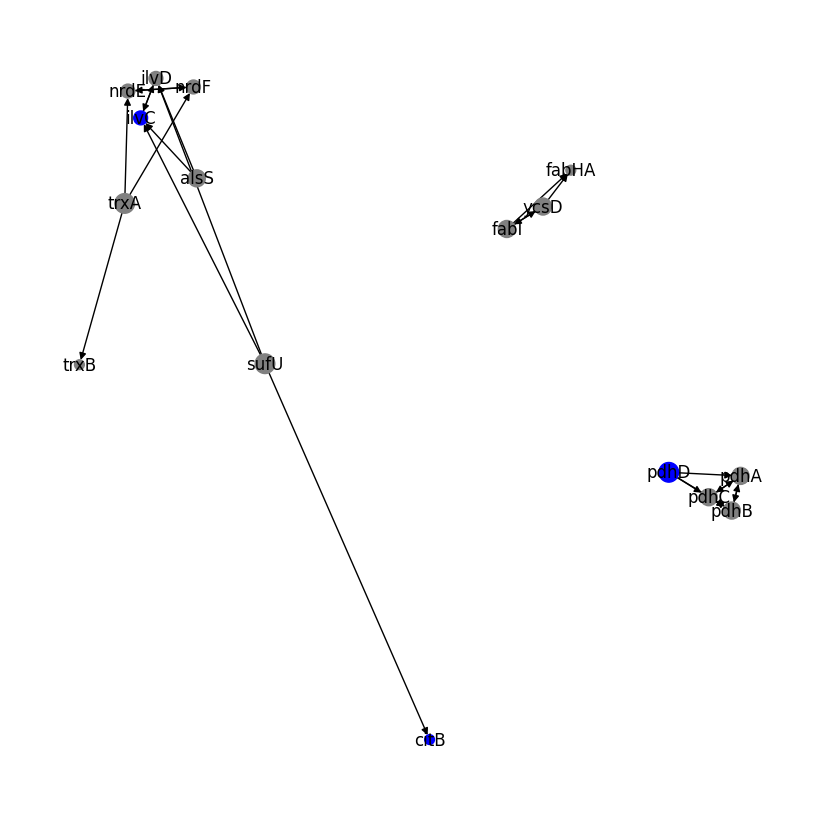

In [49]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=1e-5)
nx.draw(G,
#        pos=pos,
       with_labels = True,
       node_size=[i*50 for i in degree],
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map
       )
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_transport_neighborhood.svg',format='SVG')

#### Are any of the nodes essential in the FS?

In [ ]:
summary = pd.read_csv('./essentiality_summary.csv',index_col=1)
summary.loc[[i for i in G.nodes if i in summary.index]]['FS_essential'].value_counts()

## Subgraphs

In [ ]:
def get_edges_from_gene(gene):
    edges = set()
    for j in fwd_name_dep[gene]:
        if j==gene: continue
        edges.add((gene,j))
    for j in name_dep[gene]:
        if j==gene: continue
        edges.add((j,gene))
    return edges

def get_graph_from_gene(gene):
    import networkx as nx
    import matplotlib.pyplot as plt
    plt.rcParams['svg.fonttype'] = 'none'
    G = nx.DiGraph()
    edges = get_edges_from_gene(gene)
    for i,j in edges:
        G.add_edge(i,j)
    return G

In [ ]:
def get_color_map(G):
    color_map = []
    degree = []
    labels = {}
    for node in G:
        d = len(fwd_name_dep[node])
        degree.append(d)
        name = locus_to_name[node] if node in locus_to_name else node
        if name in confirmed_depletions:
            color_map.append('green')
        elif name in known_depletions:
            color_map.append('blue')
        else: 
            color_map.append('gray')
    #     if d > 5:
        labels[node] = locus_to_name[node] if node in locus_to_name else node
    return color_map,degree,labels

In [ ]:
for i, gene in enumerate(set(known_depletions)):
    SG = get_graph_from_gene(gene)
    if len(SG.nodes) == 0:continue
    print ("subgraph {} has {} nodes".format(i, len(SG.nodes)))
    print ("\tNodes:", SG.nodes)
    
    color_map,degree,labels = get_color_map(SG)
    if len(SG.nodes) > 4:
        plt.figure(figsize=(1.5,1.5))
    else:
        plt.figure(figsize=(1,1))
        
        
    pos = nx.spring_layout(SG, k=1.0)
    nx.draw(SG,
           pos=pos,
           with_labels = True,
    #        node_size=[i*50 for i in degree],
    #        arrowsize=20,
    #        width = 1.5,
    #        font_size=15,
           node_color=color_map
           )
#     plt.savefig('figures/network_neighbor_sg_{}_spoAQ.svg'.format(i),format='SVG')

In [ ]:
G = nx.DiGraph()

edges = set()
for i, gene in enumerate(set(known_depletions)):
    edges = edges | get_edges_from_gene(gene)

for i,j in edges:
    G.add_edge(i,j)
    
pos = nx.spring_layout(G, k=2.0)
color_map,degree,labels = get_color_map(G)

nx.draw(G,
       pos=pos,
       with_labels = True,
#        node_size=[i*50 for i in degree],
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map
       )
#     plt.savefig('figures/network_neighbor_sg_{}_spoAQ.svg'.format(i),format='SVG')

In [ ]:
for i in G.edges:
    print(i)

In [ ]:
import json
d =nx.cytoscape_data(G)
with open('network.json','w') as f:
    json.dump(d,f)